## In this notebook iwe will emulate Potential Temperature variable of the WRF data . We have saprately fetched the data from 2019-05-01 to 2019-05-31 in pickel files. 

## The location we will focus at UMBC in Maryland. 

## The data will be divided in 70% training and 30% testing, ie Model will be roughly trained on first 20 days and evalute on next 10 days.

In [2]:
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import autokeras as ak
from math import sqrt
from tensorflow.keras.regularizers import l2, l1
import time
from mpl_toolkits.basemap import Basemap
import argparse
import matplotlib as mpl

### Retreiving data from Pickel file

In [3]:
datafile = open('PickleDataFiles/wrfout_d01_2019_05_01_to_2019_05_31_TPWHNO', 'rb')      
data = pickle.load(datafile) 

### For this notebook we will focus on 'latitude', 'longitude', 'Temperature' variables

In [4]:
data.keys()

dict_keys(['times', 'latitude', 'longitude', 'temperature', 'xWind', 'yWind', 'zWind', 'pressure', 'no2', 'no', 'o3', 'hno3', 'h2o2'])

### Among all the latitude longitude points, these points lies in UMBC

In [5]:
#'UMBC'
print(data['latitude'][17][20])
print(data['longitude'][17][20])

39.589718
-76.512085


In [6]:
print('times :' + str(len(data['times'])))
print('Lat :' + str(data['latitude'].shape))
print('Lon :' + str(data['longitude'].shape))
print('Pressure :' + str(data['pressure'].shape))
print('Temperature :' + str(data['temperature'].shape))

times :744
Lat :(29, 29)
Lon :(29, 29)
Pressure :(744, 29, 29, 29)
Temperature :(744, 29, 29, 29)


- We can see above that total we have 29*29 Latitude and Longitude Points
- We have 744 data point for a month ie, we have data for each hour (31*24 = 744)
- For Temperature and Pressure we have 29 level of the data and at each level we have 29*29 gird points at each lat-lon point

### Next we will retrieve all the 29 level data point of all the variables at the UMBC. Storing them to respective list

In [6]:
lat_loc=17
lon_loc=20
temperature =[]
pressure = []
xWind = []
yWind = []
zWind = []
no2 = []
no = []
o3 = []
hno3 = []
h2o2 = []
for i in range(len(data['temperature'])):
    temperature.append(data['temperature'][i][lat_loc][lon_loc])
    pressure.append(data['pressure'][i][lat_loc][lon_loc])
    xWind.append(data['xWind'][i][lat_loc][lon_loc])
    yWind.append(data['yWind'][i][lat_loc][lon_loc])
    zWind.append(data['zWind'][i][lat_loc][lon_loc])
    no2.append(data['no2'][i][lat_loc][lon_loc])
    no.append(data['no'][i][lat_loc][lon_loc])
    o3.append(data['o3'][i][lat_loc][lon_loc])
    hno3.append(data['hno3'][i][lat_loc][lon_loc])
    h2o2.append(data['h2o2'][i][lat_loc][lon_loc])
    

### As this is time series data so first thing came to mind is to use RNN. A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step. 
### This is Univariate RNN model, so our input and output variable are both Temperature.
### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [7]:

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            print("break")
            print(i)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
X,y=split_sequence(temperature, 3)

break
741


In [9]:
X.shape

(741, 3, 29)

In [10]:
y.shape

(741, 29)

### Splitting the data with test size of 33 %

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
print(X_train.shape)
print(X_test.shape)

(496, 3, 29)
(245, 3, 29)


### In order to make the model learning easy, lets standardise the input data

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)


In [15]:
print(X_train.shape)
print(X_test.shape)

(496, 3, 29)
(245, 3, 29)


### Creating our own loss function as root mean square

In [18]:
def my_objective(y_pred,  y_true):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

How autokeras library works is that, it gives us best neural network architecture on the given input data.

We can use different block such as DenseBlock, ConvBlock, RNNBlock based on our problem.

The input_node is to accept the input datato the model. 
Then we added RNN block with few parameter inputs. This requires little bit of hyperparameter tunning on below variables.
    - return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False. This was set to True to get the full sequence.
    - bidirectional: It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - layer_type: it can be lstm/GRU. if left empty the RNNBlock will identify the best one.
    
For the ouptut we define RegressionHead with our own loss.

Lastly setting the autokeras AutoModel, specifying input_node, output_node and max_trials. In each epoch the autokers will try different architecture upto max_trial

Then standard Model.fit with input and output data with number of epochs

In [60]:
input_node = ak.Input()
output_node2 = ak.RNNBlock(return_sequences=True,bidirectional=True,layer_type='lstm')(input_node) 

output_node = ak.RegressionHead(loss=my_objective)(output_node2)

auto_model = ak.AutoModel(inputs=input_node,outputs=output_node,overwrite=True,max_trials=50)

In [61]:

start_time = time.time()
auto_model.fit(X_train, y_train, epochs=100)

Trial 11 Complete [00h 00m 14s]
val_loss: 1.0625948905944824

Best val_loss So Far: 0.5758088231086731
Total elapsed time: 00h 04m 09s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
17/17 [==============================] - 1s 71ms/step - loss: 13.0468 - mean_squared_error: 170.3276 - val_loss: 12.5785 - val_mean_squared_error: 158.3277
Epoch 2/100
17/17 [==============================] - 0s 10ms/step - loss: 11.7030 - mean_squared_error: 137.5237 - val_loss: 9.9807 - val_mean_squared_error: 99.6894
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 8.3234 - mean_squared_error: 70.3523 - val_loss: 6.4481 - val_mean_squared_error: 41.6073
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 5.5074 - mean_squared_error: 30.5460 - val_loss: 5.0331 - val_mean_squared_error: 25.3634
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 4.6745 - mean_squared_error: 21.9134 - val_loss: 4.7201 - val_mean_squared_error: 22.3031
Epo

17/17 [==============================] - 0s 10ms/step - loss: 0.4980 - mean_squared_error: 0.2493 - val_loss: 0.4807 - val_mean_squared_error: 0.2348


In [62]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 273.4953634738922 seconds ---


### Now we can make predictions on the model we just trained.

In [63]:
start_time_prediction = time.time()
predicted_temp=auto_model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time_prediction))

--- 2.5334525108337402 seconds ---


### Export model to save the config

In [64]:
auto_model_t=auto_model.export_model()

In [65]:
f = open("images_data/Temperature_Model_config_UMBC.txt", "w")
f.write(str(auto_model_t.get_config()))
f.close()

### Save the trained model to make further predictions

In [67]:
try:
    auto_model_t.save("Model_save/model_autokeras_temperature_UMBC", save_format="tf")
except Exception:
    auto_model_t.save("Model_save/model_autokeras_temperature_UMBC.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_save/model_autokeras_temperature_UMBC/assets


In [66]:
auto_model_t.get_config()

{'name': 'functional_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 3, 29),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'class_name': 'LSTM',
     'config': {'name': 'lstm',
      'trainable': True,
      'dtype': 'float32',
      'return_sequences': True,
      'return_state': False,
      'go_backwards': False,
      'stateful': False,
      'unroll': False,
      'time_major': False,
      'units': 29,
      'activation': 'tanh',
      'recurrent_activation': 'sigmoid',
      'use_bias': True,
      'kernel_initializer': {'class_name': 'GlorotUniform',
       'config': {'seed': None}},
      'recurrent_initializer': {'class_name': 'Orthogonal',
       'config': {'gain': 1.0, 'seed': None}},
      'bias_initializer': {'cl

In [30]:
predicted_temp

array([[14.33883  , 14.807473 , 14.623261 , ..., 18.71816  , 19.680351 ,
        20.062788 ],
       [19.582819 , 20.087566 , 20.373684 , ...,  6.1222825,  8.983146 ,
        11.630021 ],
       [ 3.3779075,  2.5521183,  3.9426808, ..., 18.668306 , 20.835896 ,
        20.94301  ],
       ...,
       [ 2.101042 ,  1.0261078,  2.8790443, ..., 18.164217 , 20.613417 ,
        20.965784 ],
       [20.936052 , 20.920996 , 20.110607 , ..., 20.964813 , 20.952826 ,
        20.765469 ],
       [12.828563 , 13.880074 , 14.794094 , ..., 17.702381 , 17.825802 ,
        17.553787 ]], dtype=float32)

### R-squared is a relative measure of fit, R-squared is around 98% reveals that 98% of the data fits the regression model.
### RMSE is an absolute measure of fit. RMSE is measure of the average deviation of the estimates from the observed values or is the square root of the variance of the residuals.

In [55]:
r2 = r2_score(predicted_temp,y_test)
rmse = sqrt(mean_squared_error(predicted_temp,y_test))

In [56]:
print(r2)
print(rmse)

0.9814436868680273
0.5837368903229837


### Lets Visualize the Test vs Predicted data

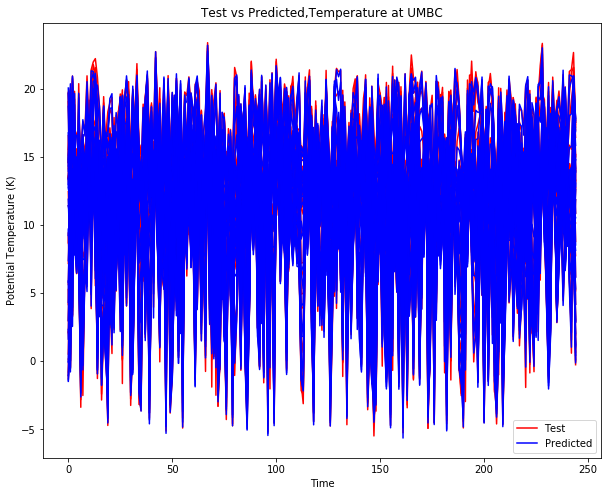

In [57]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted,Temperature at UMBC')
plt.xlabel('Time')
plt.ylabel('Potential Temperature (K)')
plt.plot(y_test, 'r',label='Test')
plt.plot(predicted_temp, 'b',label='Predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('images_data/Temperature at UMBC.png')
#plt.legend()
plt.show()

### The plot looks convencing as almost all test data points are covered by predicted data. To get a closer look lets plot the single time and location

### The plot looks convencing as almost all test data points are covered by predicted data. To get a closer look lets plot the single time and location

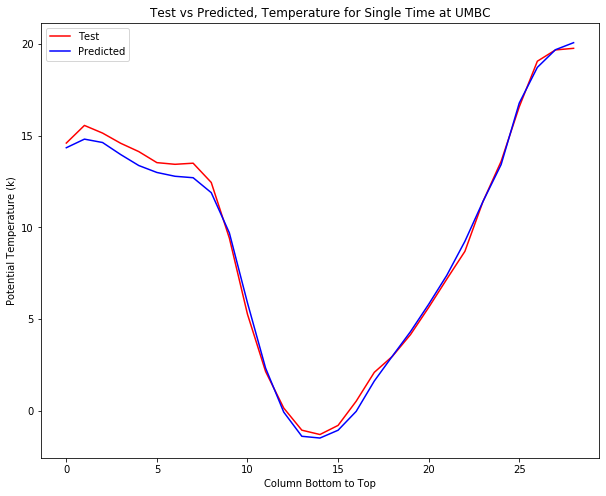

In [59]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Temperature for Single Time at UMBC')
plt.xlabel('Column Bottom to Top')
plt.ylabel('Potential Temperature (k)')
plt.plot(y_test[0], 'r',label= 'Test')
plt.plot(predicted_temp[0], 'b', label= 'Predicted')
plt.legend()
plt.savefig('images_data/Temperature for Single Time at UMBC_0.png')
plt.show()
#plt.savefig('Data/autoKeras_500_trials_1000epochs.png')